In [2]:
import os
import json
import geopandas as gpd
import requests
import osmnx as ox
from dotenv import load_dotenv
from sentinelsat import geojson_to_wkt
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session
from pydantic import BaseModel

In [3]:
class ExtractBox(BaseModel):
    location: str
    distance: float = 1000.0  # Default distance in meters
    filepath: str

def extract_bbox(**kwargs):
    input = ExtractBox(**kwargs)
    location = input.location
    distance = input.distance
    filepath = input.filepath

    # Generate GeoDataFrame from location
    gdf = ox.geocode_to_gdf(location)
    gdf.to_file(filepath, driver="GeoJSON")
    print(f"✅ GeoJSON file saved as {filepath}")

    # Compute bounding box
    minx, miny, maxx, maxy = gdf.total_bounds

    # ✅ Return structured output
    return {
        "file_path": filepath,
        "bbox": [minx, miny, maxx, maxy]
    }

In [4]:
bbox = extract_bbox(location="Uttarakhand", distance=1000, filepath="uttarakhand.geojson")["bbox"]


✅ GeoJSON file saved as uttarakhand.geojson


In [5]:
bbox

[np.float64(77.57133),
 np.float64(28.7243243),
 np.float64(81.044789),
 np.float64(31.459016)]

e:\CodeBook\ISRO\.venv\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: Several features with id = 27281439 have been found. Altering it to be unique. This warning will not be emitted anymore for this layer
  return ogr_read(


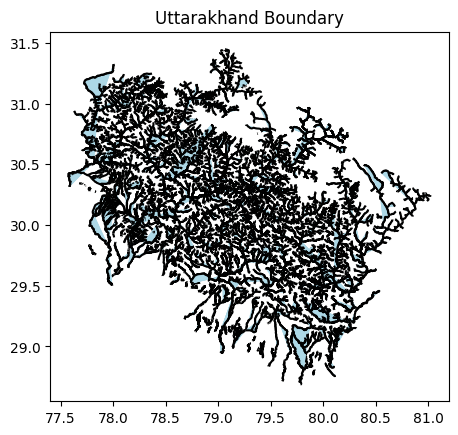

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the GeoJSON file
gdf = gpd.read_file("uttarakhand_rivers.geojson")

# Plot
gdf.plot(edgecolor='black', facecolor='lightblue')
plt.title("Uttarakhand Boundary")
plt.show()


In [7]:
import folium
import geopandas as gpd

# Load the GeoJSON
gdf = gpd.read_file("uttarakhand.geojson")

# Get center of the shape
center = [gdf.geometry.centroid.y.mean(), gdf.geometry.centroid.x.mean()]

# Create folium map centered at the shape
m = folium.Map(location=center, zoom_start=8)

# Add the GeoJSON overlay to the map
folium.GeoJson(gdf, name="Uttarakhand").add_to(m)

# Optional: add layer control
folium.LayerControl().add_to(m)

# Save the interactive map to HTML
m.save("uttarakhand_map.html")

print("✅ Saved to uttarakhand_map.html")


✅ Saved to uttarakhand_map.html


C:\Users\Debanjan\AppData\Local\Temp\ipykernel_33664\2578353760.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center = [gdf.geometry.centroid.y.mean(), gdf.geometry.centroid.x.mean()]


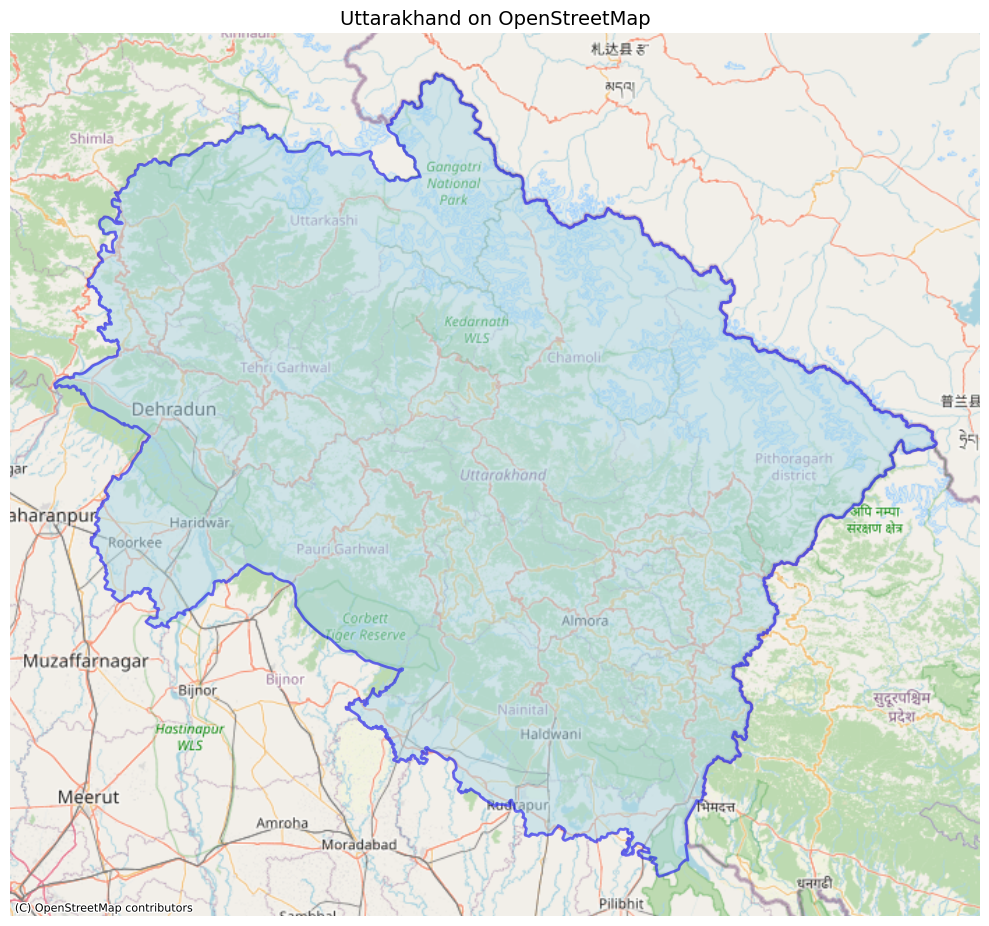

In [8]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx  # For OSM basemaps

# Load the GeoJSON boundary
gdf = gpd.read_file("uttarakhand.geojson")

# Project to Web Mercator for tile overlay
gdf = gdf.to_crs(epsg=3857)

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, facecolor='lightblue', edgecolor='blue', linewidth=2, alpha=0.5)

# Add OpenStreetMap tiles
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Clean up
ax.set_title("Uttarakhand on OpenStreetMap", fontsize=14)
ax.set_axis_off()
plt.tight_layout()
plt.show()


In [1]:
import os
from dotenv import load_dotenv
load_dotenv()
client_id = os.getenv("CLIENT_ID")
client_secret = os.getenv("CLIENT_SECRET")



In [9]:
##########################
# Authentication Utility #
##########################
def get_access_token():
    client = BackendApplicationClient(client_id=client_id)
    oauth = OAuth2Session(client=client)
    token = oauth.fetch_token(
        token_url='https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token',
        client_secret=client_secret,
        include_client_id=True
    )
    return token['access_token']

In [34]:

evalscripts = {
    "dem": '''
function setup() {
  return { input: ["DEM"], output: { bands: 1 } };
}
function evaluatePixel(sample) {
  return [sample.DEM];
}''',
    "lulc": '''
function setup() {
  return {
    input: ["Map"],
    output: { bands: 1 }
  };
}
function evaluatePixel(sample) {
  return [sample.Map];
}
''',
    "ndvi": '''
function setup() {
  return { input: ["B04", "B08"], output: { bands: 1 } };
}
function evaluatePixel(sample) {
  let ndvi = (sample.B08 - sample.B04) / (sample.B08 + sample.B04);
  return [ndvi];
}''',
    "soil_saturation": '''
function setup() {
  return { input: ["VV", "VH"], output: { bands: 2 } };
}
function evaluatePixel(sample) {
  return [sample.VV, sample.VH];
}''',
    "ndwi": '''
function setup() {
  return { input: ["B03", "B08"], output: { bands: 1 } };
}
function evaluatePixel(sample) {
  let ndwi = (sample.B03 - sample.B08) / (sample.B03 + sample.B08);
  return [ndwi];
}''',
    "aod": '''
function setup() {
  return { input: ["AER_AI_340_380"], output: { bands: 1 } };
}
function evaluatePixel(sample) {
  return [sample.AER_AI_340_380];
}'''
}


##########################
# Dataset Type Mapping   #
##########################

SUPPORTED_DATASETS = {
    "dem": "DEM",
    "ndvi": "sentinel-2-l2a",
    "ndwi": "sentinel-2-l2a",
    "landcover": "sentinel-2-l2a",
    "soil_saturation": "sentinel-1-grd",
    "aod": "modis",
    "lulc": "WorldCover"

}


#####################
# Payload Generator #
#####################

class CreatePayload(BaseModel):
    dataset_type: str
    bbox: list
    time_from: str = "2023-01-01T00:00:00Z"
    time_to: str = "2023-12-31T23:59:59Z"
    evalscript: str = None

def create_payload(**kwargs):
    input = CreatePayload(**kwargs)

    dataset_type = input.dataset_type.lower()
    bbox = input.bbox
    time_from = input.time_from
    time_to = input.time_to
    evalscript = input.evalscript

    if dataset_type not in SUPPORTED_DATASETS:
        raise ValueError(f"Unsupported dataset type: {dataset_type}")

    if not evalscript:
        if dataset_type not in evalscripts:
            raise ValueError(f"No default evalscript available for dataset_type '{dataset_type}'")
        evalscript = evalscripts[dataset_type]

    print(f"🛠️ Creating payload for dataset: {dataset_type}, time: {time_from} to {time_to}")

    return {
        "input": {
            "bounds": {
                "bbox": bbox,
                "properties": {"crs": "http://www.opengis.net/def/crs/EPSG/0/4326"}
            },
            "data": [{
                "type": SUPPORTED_DATASETS[dataset_type],
                "dataFilter": {
                    "timeRange": {
                        "from": time_from,
                        "to": time_to
                    }
                }
            }]
        },
        "output": {
            "width": 512,
            "height": 512,
            "responses": [{
                "identifier": "default",
                "format": {"type": "image/tiff"}
            }]
        },
        "evalscript": evalscript
    }


##################
# Process Handler #
##################

class ProcessRequest(BaseModel):
    payload: dict
    filepath: str

def process_request(**kwargs) -> str:
    input = ProcessRequest(**kwargs)
    payload = input.payload
    filepath = input.filepath

    if not filepath.endswith(".tif"):
        filepath += ".tif"

    access_token = get_access_token()
    headers = {
        "Authorization": f"Bearer {access_token}",
        "Content-Type": "application/json"
    }

    print(f"🚀 Sending request to Sentinel Hub...")
    response = requests.post(
        "https://sh.dataspace.copernicus.eu/api/v1/process",
        headers=headers,
        data=json.dumps(payload)
    )

    if response.ok:
        with open(filepath, "wb") as f:
            f.write(response.content)
        print(f"✅ Processed data saved to {filepath}")
        return filepath
    else:
        print("❌ Request failed:", response.status_code)
        try:
            print("📄 Error details:", response.json())
        except:
            print("📄 Error content:", response.text)
        raise RuntimeError(f"Sentinel Hub request failed with status {response.status_code}")


In [11]:
payload = create_payload(dataset_type="dem", bbox=bbox, time_from="2023-01-01T00:00:00Z", time_to="2023-12-31T23:59:59Z")

🛠️ Creating payload for dataset: dem, time: 2023-01-01T00:00:00Z to 2023-12-31T23:59:59Z


In [12]:
process_request(
    payload=payload,
    filepath="uttarakhand_dem.tif"
)

🚀 Sending request to Sentinel Hub...
✅ Processed data saved to uttarakhand_dem.tif


'uttarakhand_dem.tif'

In [35]:
payload = create_payload(dataset_type="lulc", bbox=bbox, time_from="2023-01-01T00:00:00Z", time_to="2023-12-31T23:59:59Z")

🛠️ Creating payload for dataset: lulc, time: 2023-01-01T00:00:00Z to 2023-12-31T23:59:59Z


In [36]:
process_request(
    payload=payload,
    filepath="uttarakhand_lulc.tif"
)

🚀 Sending request to Sentinel Hub...
❌ Request failed: 400
📄 Error details: {'error': {'status': 400, 'reason': 'Bad Request', 'message': 'Invalid collection type. If using your own data collection, make sure to use the appropriate prefix.', 'code': 'COMMON_BAD_PAYLOAD', 'errors': {'parameter': 'input->data[0]->type', 'invalidValue': 'WorldCover'}}}


RuntimeError: Sentinel Hub request failed with status 400

In [26]:
import cdsapi

c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-single-levels-monthly-means',
    {
        'product_type': 'monthly_averaged_reanalysis',
        'variable': 'total_precipitation',
        'year': '2023',
        'month': '08',
        'time': '00:00',
        'area': [30.5, 78.0, 30.0, 78.5],  # [North, West, South, East]
        'format': 'netcdf',
    },
    'total_rain_august.nc'
)


2025-06-24 09:52:12,276 INFO [2025-06-16T00:00:00] CC-BY licence to replace Licence to use Copernicus Products on 02 July 2025. More information available [here](https://forum.ecmwf.int/t/cc-by-licence-to-replace-licence-to-use-copernicus-products-on-02-july-2025/13464)
2025-06-24 09:52:12,277 INFO [2025-06-10T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-06-24 09:52:12,278 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-06-24 09:52:13,116 INFO Request ID is f19635d5-5f58-4c00-a6a2-10288d46947f
2025-06-24 09:52:13,395 INFO status has been updated to accepted
2025-06-24 09:52:22,864 INFO status has been updated to running
2025-06-24 09:52:28,268 INFO status has been updated to successful


1a9c814c809dc4b36cb06b289addfc1.nc:   0%|          | 0.00/25.0k [00:00<?, ?B/s]

'total_rain_august.nc'

In [28]:
import xarray as xr
import rasterio
from rasterio.transform import from_origin

# === 1. Load the NetCDF file ===
ds = xr.open_dataset("total_rain_august.nc")

# === 2. Extract data ===
precip = ds['tp'][0]  # 'tp' is total precipitation, [0] if single timestep

# === 3. Get coordinates and resolution ===
lat = precip.latitude.values
lon = precip.longitude.values
data = precip.values

# Flip if lat is decreasing
if lat[0] > lat[-1]:
    lat = lat[::-1]
    data = data[::-1, :]

# === 4. Define affine transform ===
res_lon = abs(lon[1] - lon[0])
res_lat = abs(lat[1] - lat[0])
transform = from_origin(west=lon[0], north=lat[-1] + len(lat) * res_lat, xsize=res_lon, ysize=res_lat)

# === 5. Save as GeoTIFF ===
new_dataset = rasterio.open(
    "total_precipitation_august.tif",
    'w',
    driver='GTiff',
    height=data.shape[0],
    width=data.shape[1],
    count=1,
    dtype='float32',
    crs='EPSG:4326',
    transform=transform,
)

new_dataset.write(data.astype('float32'), 1)
new_dataset.close()

print("✅ Saved as total_precipitation_august.tif")


✅ Saved as total_precipitation_august.tif


In [30]:
import osmnx as ox
import geopandas as gpd

# Get rivers near a place
gdf = ox.features_from_place("Uttarakhand, India", {"waterway": True})

# Filter only rivers
rivers = gdf[gdf['waterway'].isin(['river', 'stream'])]

# Save as GeoJSON
rivers.to_file("uttarakhand_rivers.geojson", driver="GeoJSON")

print("✅ Saved uttarakhand_rivers.geojson")


e:\CodeBook\ISRO\.venv\Lib\site-packages\osmnx\_overpass.py:267: UserWarning: This area is 25 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)


✅ Saved uttarakhand_rivers.geojson


In [1]:
import geopandas as gpd
import rasterio
import numpy as np
from shapely.geometry import Point
from rasterio.transform import from_origin
from scipy.spatial import cKDTree
from rasterio.features import rasterize

# === Load region and rivers ===
region = gpd.read_file("uttarakhand.geojson").to_crs(epsg=32644)
rivers = gpd.read_file("uttarakhand_rivers.geojson").to_crs(region.crs)

# === Define raster grid ===
res = 100  # Resolution in meters
minx, miny, maxx, maxy = region.total_bounds
width = int((maxx - minx) // res)
height = int((maxy - miny) // res)
transform = from_origin(minx, maxy, res, res)

# === Generate all pixel centers ===
x_coords = np.linspace(minx + res/2, maxx - res/2, width)
y_coords = np.linspace(miny + res/2, maxy - res/2, height)
grid_points = np.array([(x, y) for y in y_coords[::-1] for x in x_coords])

# === Create river points for distance tree ===
river_points = np.vstack([np.array(geom.coords) for geom in rivers.geometry if geom.geom_type == 'LineString'])
tree = cKDTree(river_points)

# === Compute distance to nearest river (in meters) ===
dists, _ = tree.query(grid_points, k=1)
distance_raster = dists.reshape((height, width)).astype(np.float32)

# === Save as GeoTIFF ===
with rasterio.open(
    "river_proximity.tif", 'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,
    dtype='float32',
    crs='EPSG:32644',
    transform=transform
) as dst:
    dst.write(distance_raster, 1)

print("✅ Proximity raster saved as river_proximity.tif")


e:\CodeBook\ISRO\.venv\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: Several features with id = 27281439 have been found. Altering it to be unique. This warning will not be emitted anymore for this layer
  return ogr_read(


✅ Proximity raster saved as river_proximity.tif


In [38]:
import geopandas as gpd
region = gpd.read_file("uttarakhand.geojson")
print(region.crs)


EPSG:4326


In [ ]:
def load_and_clip_raster(path, region):
    with rasterio.open(path) as src:
        raster_crs = src.crs
        if region.crs != raster_crs:
            region = region.to_crs(raster_crs)  # 🔁 Reproject to match raster

        out_image, out_transform = mask(src, region.geometry, crop=True)
        out_meta = src.meta.copy()
        out_meta.update({
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })
        return out_image[0], out_meta


In [37]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import numpy as np
import matplotlib.pyplot as plt

# ---------- Step 1: Load vector boundary ----------
region = gpd.read_file("uttarakhand.geojson")
region = region.to_crs("EPSG:32644")

def load_and_clip_raster(path, region):
    with rasterio.open(path) as src:
        out_image, out_transform = mask(src, region.geometry, crop=True)
        out_meta = src.meta.copy()
        out_meta.update({
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })
        return out_image[0], out_meta

# ---------- Step 2: Load and normalize rasters ----------
def normalize(arr):
    arr = np.where(np.isnan(arr), 0, arr)
    return (arr - arr.min()) / (arr.max() - arr.min())

dem, _ = load_and_clip_raster("uttarakhand_dem.tif", region)
precip, _ = load_and_clip_raster("total_precipitation_august.tif", region)
rivers, meta = load_and_clip_raster("uttarakhand_rivers.tif", region)

# ---------- Step 3: Normalize ----------
dem_norm = normalize(dem)
precip_norm = normalize(precip)
rivers_norm = normalize(rivers)

# ---------- Step 4: Calculate flood risk ----------
flood_risk = (
    0.4 * (1 - dem_norm) +   # Low elevation = high risk
    0.3 * precip_norm +      # High rain = high risk
    0.3 * (1 - rivers_norm)  # Closer to river = high risk
)

# ---------- Step 5: Save output ----------
meta.update(dtype='float32', count=1)
with rasterio.open("uttarakhand_flood_risk.tif", 'w', **meta) as dst:
    dst.write(flood_risk.astype('float32'), 1)

print("✅ Saved: uttarakhand_flood_risk.tif")

# ---------- Step 6: Show preview ----------
plt.imshow(flood_risk, cmap='Reds')
plt.title("🛑 Flood Risk Map")
plt.colorbar(label="Flood Risk (0-1)")
plt.axis('off')
plt.show()


ValueError: Input shapes do not overlap raster.